In [2]:
!pip install torch transformers datasets scikit-learn numpy matplotlib tqdm seaborn

Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-2.2.1-cp310-cp310-manylinux1_x86_64.whl (755.5 MB)
  Using cached scikit_learn-1.4.1.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Using cached matplotlib-3.8.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
  Using cached tqdm-4.66.2-py3-none-any.whl (78 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cac

  Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
wandb 0.16.4 requires protobuf!=4.21.0,<5,>=3.19.0; python_version > "3.9" and sys_platform == "linux", which is not installed.


In [1]:
import torch
from torch.utils.data import DataLoader
from transformers import CLIPProcessor, CLIPModel
from datasets import Dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import numpy as np
import matplotlib.pyplot as plt
import datasets
import sys
from tqdm import tqdm
from PIL import Image
import copy
import pandas as pd
import random
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.path.append('/home/jthr/repos/imbag')
print(sys.path)
from src.load_data import load_google_data

['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/jthr/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/local/lib/python3.10/dist-packages/nvfuser-0.1.4a0+d0bb811-py3.10-linux-x86_64.egg', '/usr/lib/python3/dist-packages', '/home/jthr/repos/imbag']


In [3]:
climate_zone_descriptions = {
    "Af": "Tropical rainforest climate",
    "Am": "Tropical monsoon climate",
    "Aw": "Tropical savanna climate (wet-dry)",
    "BWh": "Hot desert climate",
    "BWk": "Cold desert climate",
    "BSh": "Hot semi-arid climate",
    "BSk": "Cold semi-arid climate",
    "Csa": "Hot-summer Mediterranean climate",
    "Csb": "Warm-summer Mediterranean climate",
    "Csc": "Cold-summer Mediterranean climate",
    "Cwa": "Monsoon-influenced humid subtropical climate",
    "Cwb": "Subtropical highland climate with dry winters",
    "Cwc": "Cold subtropical highland climate with dry winters",
    "Cfa": "Humid subtropical climate",
    "Cfb": "Oceanic climate",
    "Cfc": "Subpolar oceanic climate",
    "Dsa": "Hot-summer Mediterranean continental climate",
    "Dsb": "Warm-summer Mediterranean continental climate",
    "Dsc": "Cold-summer Mediterranean continental climate",
    "Dsd": "Cold-summer Mediterranean continental climate with extremely cold winters",
    "Dwa": "Monsoon-influenced hot-summer humid continental climate",
    "Dwb": "Monsoon-influenced warm-summer humid continental climate",
    "Dwc": "Monsoon-influenced subarctic climate",
    "Dwd": "Monsoon-influenced subarctic climate with extremely cold winters",
    "Dfa": "Hot-summer humid continental climate",
    "Dfb": "Warm-summer humid continental climate",
    "Dfc": "Subarctic climate with cool summers",
    "Dfd": "Subarctic climate with extremely cold winters",
    "ET": "Tundra climate",
    "EF": "Ice cap climate"
}

processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14-336")


In [4]:
labels = [f"This image was taken in {c}" for c in climate_zone_descriptions.values()]

In [5]:
dataset = load_google_data("imbag_clip_dataset.hf")

In [6]:
metadata = pd.read_csv('/home/data_shares/geocv/imbag_metadata.csv')

In [7]:
captions = []

for index, row in metadata.iterrows():
    country = row["Country"]
    geocell = row["Geocell"]
    climate = row["Climate Zone"]
    caption = "this image was taken in " + country + " within geocell " + str(geocell) + " in " + climate_zone_descriptions.get(climate).lower()
    captions.append(caption)

In [8]:
unique_captions = list(set(captions))

In [9]:
len(unique_captions)

2668

In [10]:
countries = list(pd.Series(dataset["train"]["Country"]).unique())

In [11]:
def classify_image_country(example, path):
    # Load the model
    model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14-336")
    model.load_state_dict(torch.load(path))
    model.eval()

    # Load the image and preprocess it
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14-336")
    image = Image.open(example["File Path"])
    inputs = processor(text=countries, images=image, return_tensors="pt", padding=True)
#     texts = ["A photo of a road with a single yellow roadline in the center of the road", "A photo of a road with a double yellow roadline in the center of the road", "A photo of a road with a single yellow roadline on the sides of the road", "A photo of a road with only white roadlines", "A photo that does not show a road"]
#     texts = ["A photo of a street with vehicles", "A photo of an empty street with no vehicles"]
#     inputs = processor(text=texts, images=image, return_tensors="pt", padding=True)

    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)

    # Get predicted label
    logits_per_image = outputs.logits_per_image
    predicted_label = logits_per_image.argmax().item()
    
    print(f"Correct answer: {example['Country']}")
    print(f"Model Answer: {countries[predicted_label]}")
#     print(f"Model Answer: {texts[predicted_label]}")
    return predicted_label

In [12]:
def classify_image_climate(example, path):
    # Load the model
    model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14-336")
    model.load_state_dict(torch.load(path))
    model.eval()

    # Load the image and preprocess it
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14-336")
    image = Image.open(example["File Path"])
    inputs = processor(text=labels, images=image, return_tensors="pt", padding=True)

    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)

    # Get predicted label
    logits_per_image = outputs.logits_per_image
    predicted_label = logits_per_image.argmax().item()
    
    print(f"Correct answer: {climate_zone_descriptions[example['Climate Zone']]}")
    print(f"Model Answer: {labels[predicted_label]}")
    return predicted_label

In [9]:
label_index = [c for c in climate_zone_descriptions.keys()]

Correct answer: Japan
Model Answer: Japan
Correct answer: Humid subtropical climate
Model Answer: This image was taken in Humid subtropical climate


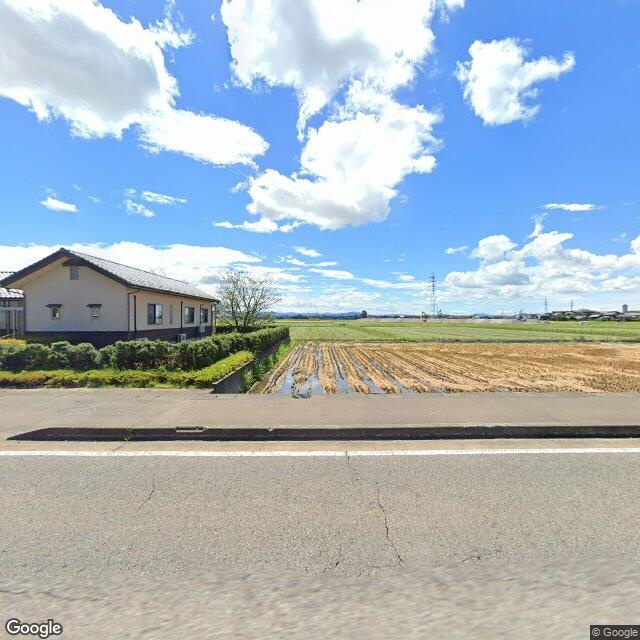

In [10]:
model = "/home/jthr/repos/imbag/models/grateful-wind-45_2.pth"


index = 55602
classify_image_country(dataset["validation"][index], model)
classify_image_climate(dataset["validation"][index], model)
Image.open(dataset["validation"][index]["File Path"])

In [13]:
countries = list(pd.Series(dataset["train"]["Country"]).unique())
climates = [c for c in climate_zone_descriptions.keys()]
geocells = list(pd.Series(dataset["train"]["Geocell"]).unique())

In [14]:
def evaluate_model_combined(dataset, model_path, batch_size=32):
    # Load the model
    model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14-336")
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Initialize lists to store true labels and predicted labels
    true_labels_combined = []
    predicted_labels_combined = []

    # Initialize CLIP processor
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14-336")

    data = copy.deepcopy(dataset)
    data.set_format(columns=['File Path', 'Climate Zone', 'Country', 'Geocell'])
    dataloader = DataLoader(data, batch_size=batch_size)
    for batch in tqdm(dataloader, desc="Evaluating:.."):
        imgs = []
        captions = []
        for country, climate, geocell, image in zip(batch["Country"], batch["Climate Zone"], batch["Geocell"], batch["File Path"]):
            img = Image.open(image)
            imgs.append(img)
            caption = "this image was taken in " + country + " within geocell " + str(geocell.item()) + " in " + climate_zone_descriptions.get(climate).lower()
            captions.append(caption)

        # Preprocess images
        inputs_combined = processor(text=unique_captions, images=imgs, return_tensors="pt", padding=True)

        true_labels_combined.extend(captions)

        # Move inputs to GPU if available
        for k, v in inputs_combined.items():
            inputs_combined[k] = v.to(device)


        # Make prediction
        with torch.no_grad():
            outputs_combined = model(**inputs_combined)

        # Get predicted labels
        logits_per_image_combined = outputs_combined.logits_per_image
        predicted_labels_combined.extend([unique_captions[i.argmax().item()] for i in logits_per_image_combined])

    return true_labels_combined, predicted_labels_combined


In [36]:
# Specify the path to the model
model_path = "/home/jthr/repos/imbag/models/grateful-wind-45_2.pth"

# Evaluate the model
true_labels_combined, predicted_labels_combined = evaluate_model_combined(dataset["validation"], model_path, batch_size=128)

Evaluating:..: 100%|██████████| 521/521 [1:23:54<00:00,  9.66s/it]


In [38]:
accuracy_combined = calculate_accuracy(true_labels_combined, predicted_labels_combined)
print("Accuracy Country:", accuracy_combined)

Accuracy Country: 0.10940524965107379


In [39]:
# Compute F1 scores
print(f1_score(true_labels_combined, predicted_labels_combined, average='micro'))
print(f1_score(true_labels_combined, predicted_labels_combined, average='macro'))
print(f1_score(true_labels_combined, predicted_labels_combined, average='weighted'))
print("-------")

0.10940524965107379
0.060245208731802
0.10290841837343316
-------


In [15]:
def evaluate_model_separate(dataset, model_path, batch_size=32):
    # Load the model
    model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14-336")
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Initialize lists to store true labels and predicted labels
    true_labels_country = []
    predicted_labels_country = []
    
    true_labels_climate = []
    predicted_labels_climate = []
    
    true_labels_geocell = []
    predicted_labels_geocell = []
    
    labels_country = [f"this image was taken in {c}" for c in countries]
    labels_geocell = [f"this image was taken in {c}" for c in geocells]
    labels_climate = [f"This image was taken in {c}" for c in climate_zone_descriptions.values()]

    # Initialize CLIP processor
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14-336")

    data = copy.deepcopy(dataset)
    data.set_format(columns=['File Path', 'Climate Zone', 'Country', 'Geocell'])
#     data = data.select(range(100))
    dataloader = DataLoader(data, batch_size=batch_size)
    for batch in tqdm(dataloader, desc="Evaluating:.."):
        imgs = []
        captions = []
        for country, climate, geocell, image in zip(batch["Country"], batch["Climate Zone"], batch["Geocell"], batch["File Path"]):
            img = Image.open(image)
            imgs.append(img)
        
        # COUNTRY
        # Preprocess images
        inputs_country = processor(text=labels_country, images=imgs, return_tensors="pt", padding=True)

        true_labels_country.extend(batch["Country"])

        # Move inputs to GPU if available
        for k, v in inputs_country.items():
            inputs_country[k] = v.to(device)


        # Make prediction 
        with torch.no_grad():
            outputs_country = model(**inputs_country)
        
        # CLIMATE
        # Preprocess images
        inputs_climate = processor(text=labels_climate, images=imgs, return_tensors="pt", padding=True)

        true_labels_climate.extend(batch["Climate Zone"])

        # Move inputs to GPU if available
        for k, v in inputs_climate.items():
            inputs_climate[k] = v.to(device)


        # Make prediction
        with torch.no_grad():
            outputs_climate = model(**inputs_climate)
            
        # GEOCELL
        # Preprocess images
        inputs_geocell = processor(text=labels_geocell, images=imgs, return_tensors="pt", padding=True)

        true_labels_geocell.extend(batch["Geocell"])

        # Move inputs to GPU if available
        for k, v in inputs_geocell.items():
            inputs_geocell[k] = v.to(device)


        # Make prediction
        with torch.no_grad():
            outputs_geocell = model(**inputs_geocell)
            

        # Get predicted labels
        logits_per_image_country = outputs_country.logits_per_image
        predicted_labels_country.extend([countries[i.argmax().item()] for i in logits_per_image_country])

        logits_per_image_climate = outputs_climate.logits_per_image
        predicted_labels_climate.extend([climates[i.argmax().item()] for i in logits_per_image_climate])

        
        logits_per_image_geocell = outputs_geocell.logits_per_image
        predicted_labels_geocell.extend([geocells[i.argmax().item()] for i in logits_per_image_geocell])

    return true_labels_country, predicted_labels_country, true_labels_climate, predicted_labels_climate, true_labels_geocell, predicted_labels_geocell


In [16]:
model_path = "/home/jthr/repos/imbag/models/zesty-forest-48_1.pth"

# Evaluate the model
true_labels_country, predicted_labels_country, true_labels_climate, predicted_labels_climate, true_labels_geocell, predicted_labels_geocell = evaluate_model_separate(dataset["validation"], model_path, batch_size=128)

# print(f1_score(true_labels, predicted_labels, average='samples'))


Evaluating:..: 100%|██████████| 521/521 [2:37:17<00:00, 18.11s/it]  


In [19]:
accuracy_country = calculate_accuracy(true_labels_country, predicted_labels_country)
print("Accuracy Country:", accuracy_country)

accuracy_climate = calculate_accuracy(true_labels_climate, predicted_labels_climate)
print("Accuracy Climate:", accuracy_climate)

accuracy_geocell = calculate_accuracy(true_labels_geocell, predicted_labels_geocell)
print("Accuracy Geocell:", accuracy_geocell)

confusion_matrix_country = confusion_matrix(true_labels_country, predicted_labels_country)
# confusion_matrix_climate = confusion_matrix(true_labels_climate, predicted_labels_climate)
# Compute F1 scores
print(f1_score(true_labels_country, predicted_labels_country, average='micro'))
print(f1_score(true_labels_country, predicted_labels_country, average='macro'))
print(f1_score(true_labels_country, predicted_labels_country, average='weighted'))
print("-------")
print(f1_score(true_labels_climate, predicted_labels_climate, average='micro'))
print(f1_score(true_labels_climate, predicted_labels_climate, average='macro'))
print(f1_score(true_labels_climate, predicted_labels_climate, average='weighted'))
print("-------")
print(f1_score(true_labels_geocell, predicted_labels_geocell, average='micro'))
print(f1_score(true_labels_geocell, predicted_labels_geocell, average='macro'))
print(f1_score(true_labels_geocell, predicted_labels_geocell, average='weighted'))

Accuracy Country: 0.7961970795251602
Accuracy Climate: 0.6077168970330017
Accuracy Geocell: 0.1577596686326595
0.7961970795251602
0.6610701894110085
0.8067195376109896
-------
0.6077168970330017
0.39600811060106733
0.6273829290223952
-------
0.1577596686326595
0.12031972734034053
0.12662962905492395


In [64]:
confusion_matrix_country = confusion_matrix(true_labels_country, predicted_labels_country)
confusion_matrix_climate = confusion_matrix(true_labels_climate, predicted_labels_climate)

In [66]:
row_sums_country = confusion_matrix_country.sum(axis=1)  # Sum of each row
relative_confusion_matrix_country = confusion_matrix_country / row_sums_country[:, np.newaxis]


row_sums_climate = confusion_matrix_climate.sum(axis=1)  # Sum of each row
relative_confusion_matrix_climate = confusion_matrix_climate / row_sums_climate[:, np.newaxis]

/tmp/ipykernel_3753/1454545057.py:6: RuntimeWarning: invalid value encountered in divide
  relative_confusion_matrix_climate = confusion_matrix_climate / row_sums_climate[:, np.newaxis]


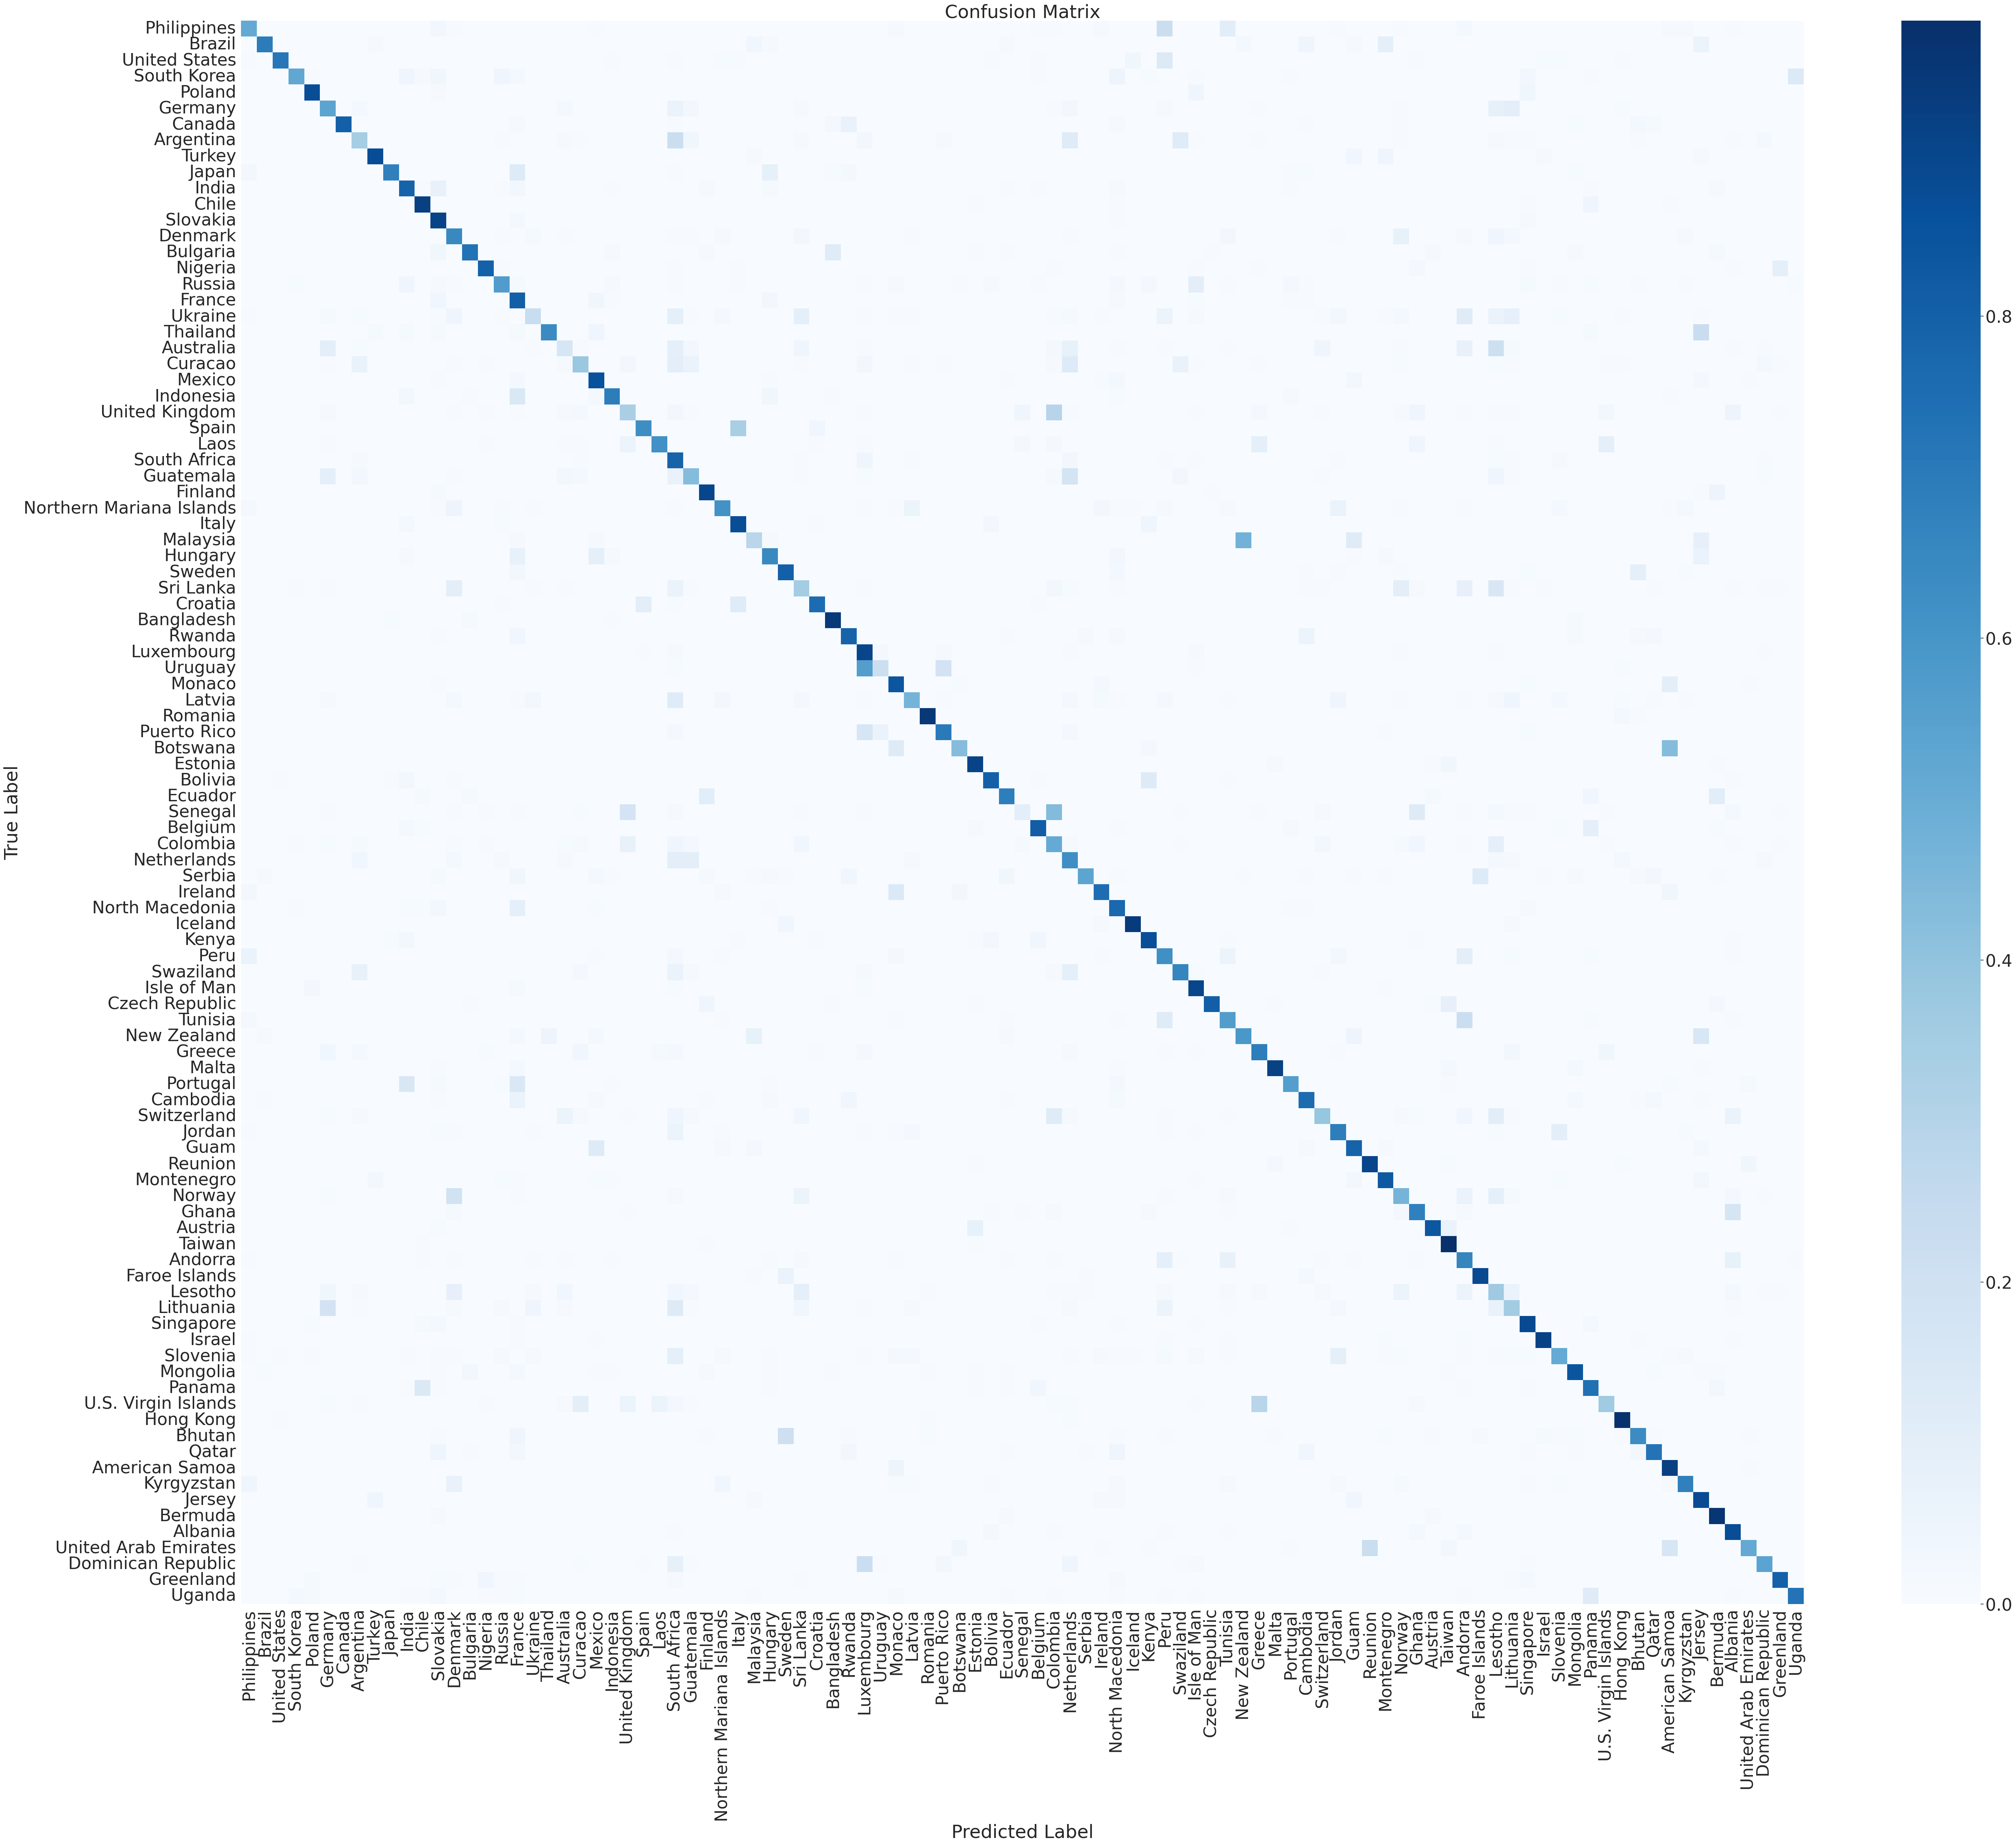

In [67]:
plt.figure(figsize=(60, 50))

sns.set_theme(font_scale=3)
sns.heatmap(relative_confusion_matrix_country, annot=False, cmap="Blues", fmt="d", xticklabels=countries, yticklabels=countries)
# plt.xticks(rotation=75)  # 'ha' parameter aligns the labels to the right
plt.tight_layout() 
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig('cm_country_largemodel.png')

Text(0.5, 1.0, 'Confusion Matrix')

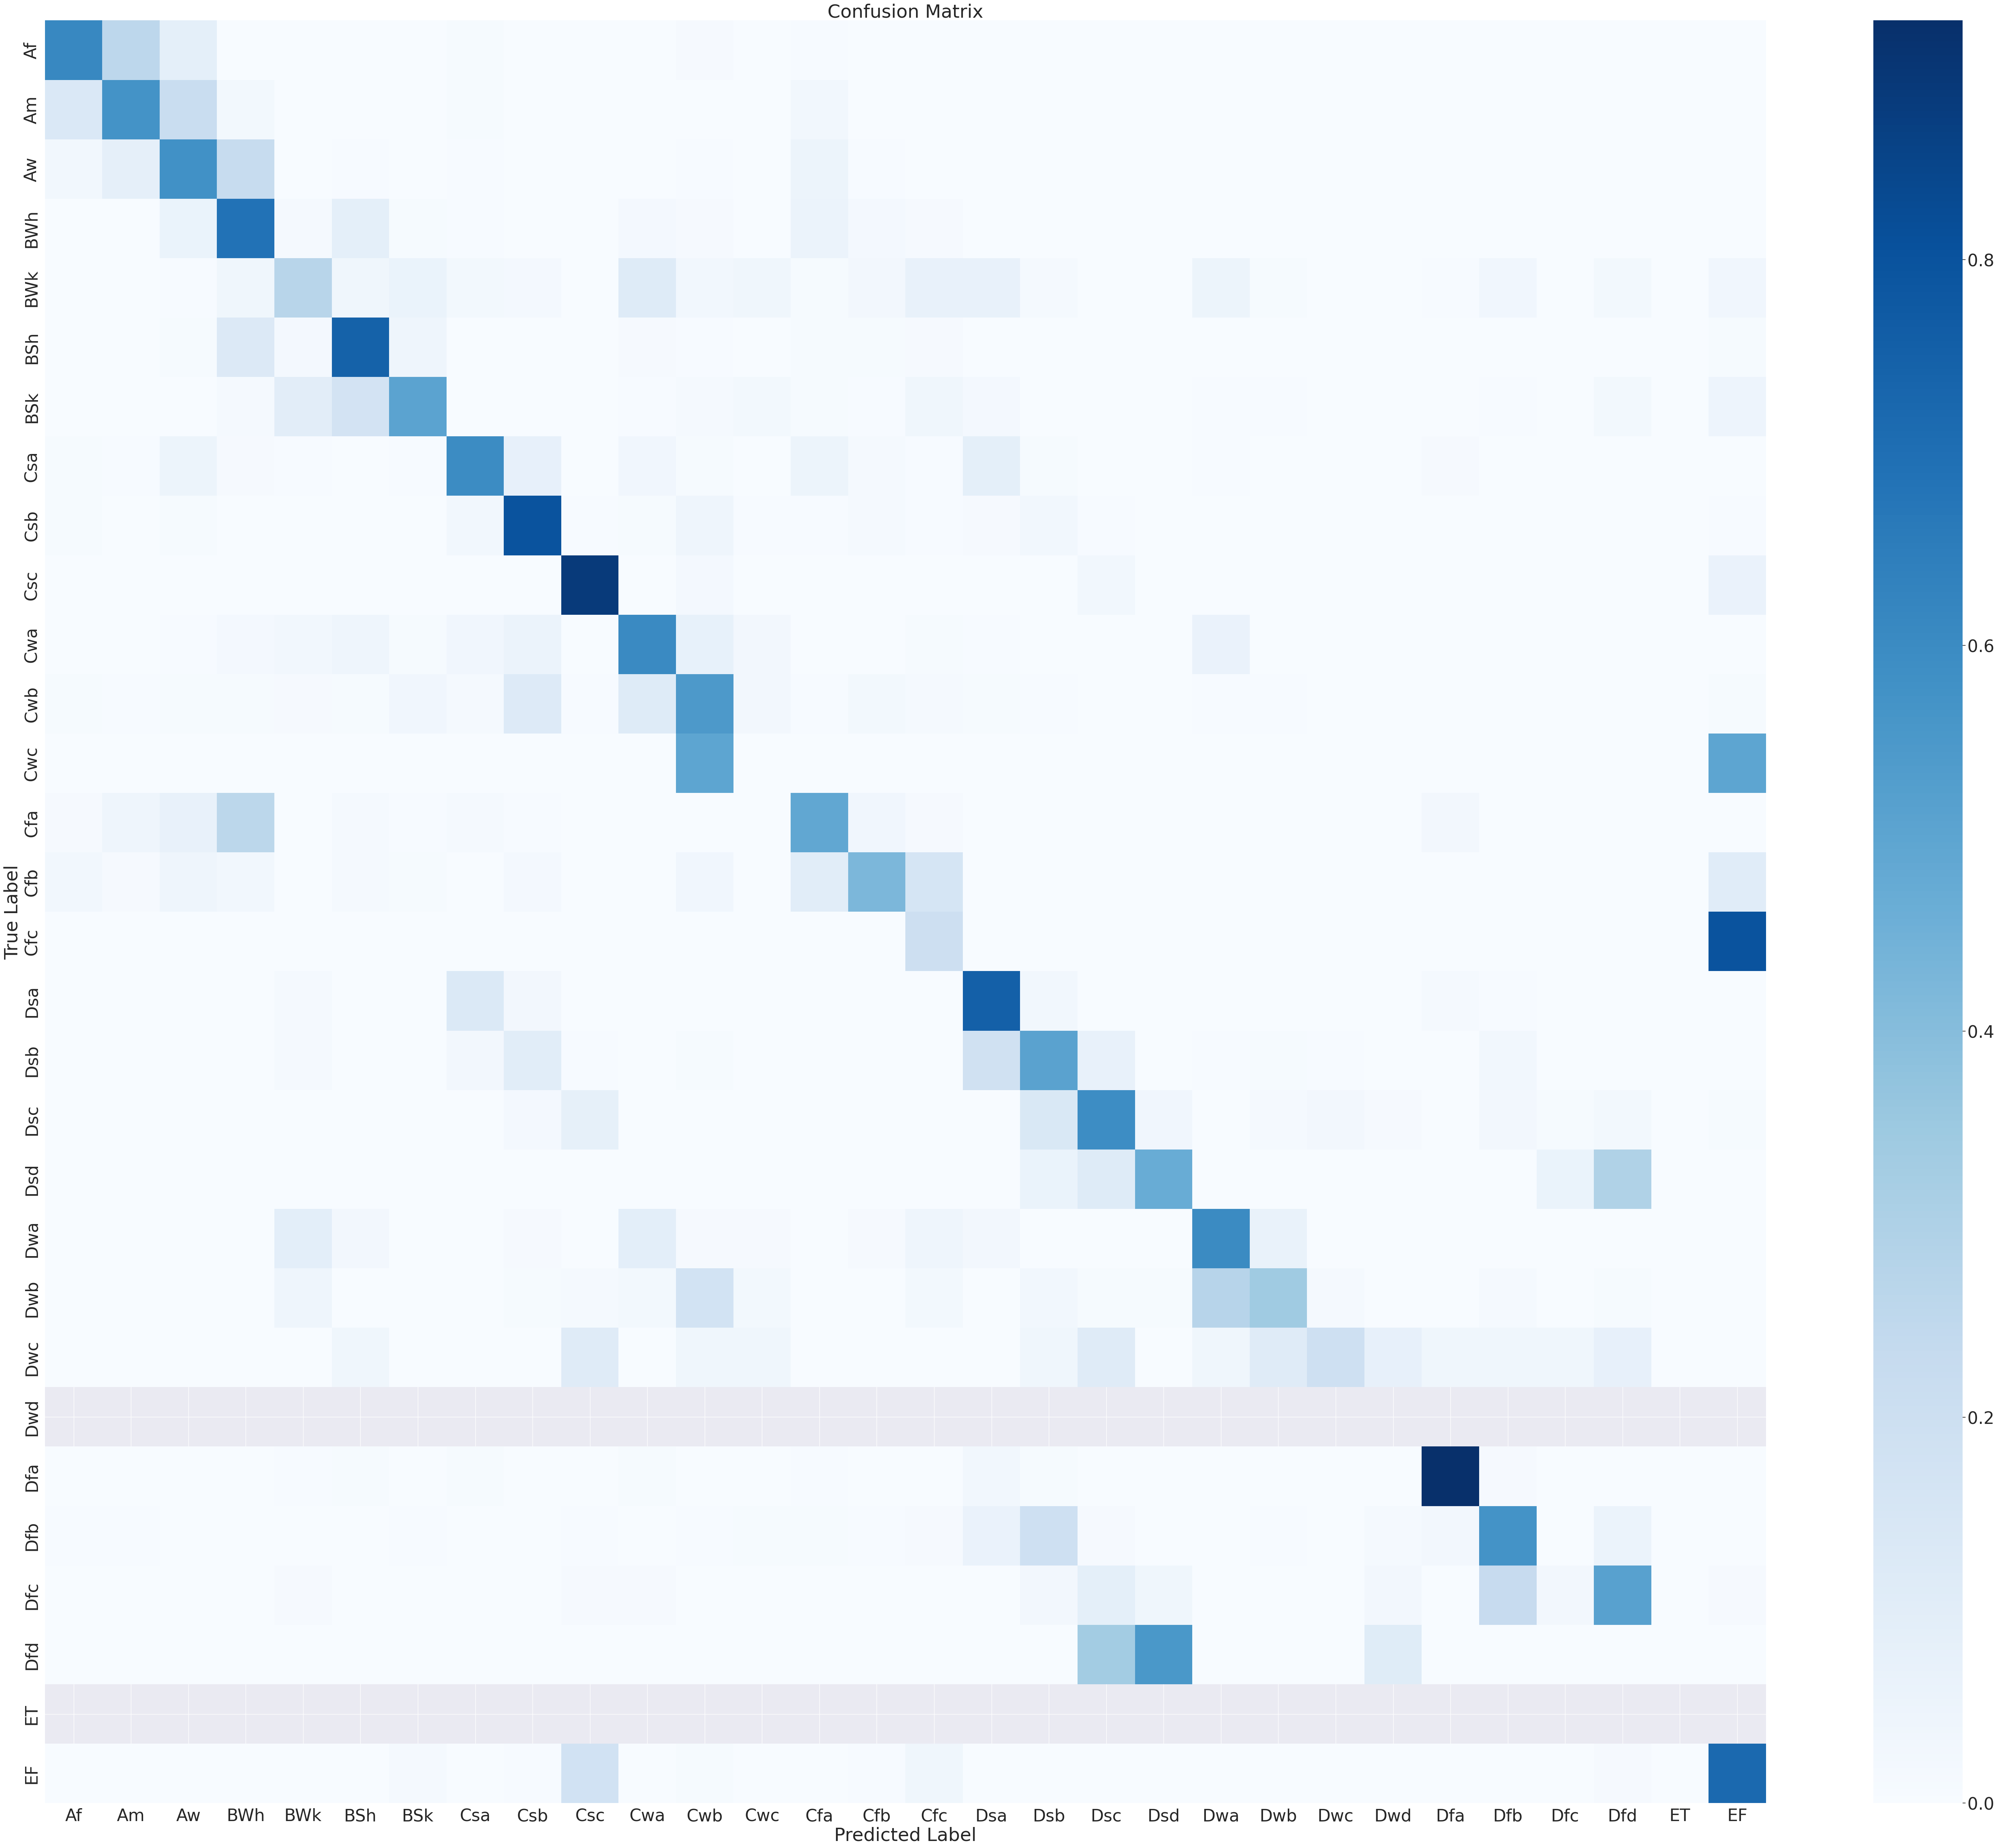

In [69]:
plt.figure(figsize=(60, 50))

sns.set_theme(font_scale=3)
sns.heatmap(relative_confusion_matrix_climate, annot=False, cmap="Blues", fmt="d", xticklabels=climates, yticklabels=climates)
# plt.xticks(rotation=75)  # 'ha' parameter aligns the labels to the right
plt.tight_layout() 
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

In [20]:
def evaluate_model_country(dataset, model_path, batch_size=32):
    # Load the model
    model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14-336")
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Initialize lists to store true labels and predicted labels
    true_labels_country = []
    predicted_labels_country = []
    true_labels_climate = []
    predicted_labels_climate = []
    true_labels_geocell = []
    predicted_labels_geocell = []

    # Initialize CLIP processor
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14-336")

    countries = list(pd.Series(dataset["Country"]).unique())
    labels_country = [f"this image was taken in {c}" for c in countries]
#     labels_climate = [f"This image was taken in {c}" for c in climate_zone_descriptions.values()]
    print(labels_country[0])
#     print(labels_climate[0])
    # Iterate over the dataset in batches
    data = copy.deepcopy(dataset)
    data.set_format(type='torch', columns=['File Path', 'Climate Zone', 'Country', 'Geocell'])
    dataloader = DataLoader(data, batch_size=batch_size)
    for batch in tqdm(dataloader, desc="Evaluating:.."):
        images = batch["File Path"]
        imgs = []
        for image in images:
            img = Image.open(image)
            imgs.append(img)

        # Preprocess images
        inputs_country = processor(text=labels_country, images=imgs, return_tensors="pt", padding=True)
#         inputs_climate = processor(text=labels_climate, images=imgs, return_tensors="pt", padding=True)

        # Store true labels
        true_labels_country.extend(batch["Country"])
#         true_labels_climate.extend(batch["Climate Zone"])
        
        # Move inputs to GPU if available
        for k, v in inputs_country.items():
            inputs_country[k] = v.to(device)


        # Make prediction
        with torch.no_grad():
            outputs_country = model(**inputs_country)
            
        
#         for k, v in inputs_climate.items():
#             inputs_climate[k] = v.to(device)


#         # Make prediction
#         with torch.no_grad():
#             outputs_climate = model(**inputs_climate)

        # Get predicted labels
        logits_per_image_country = outputs_country.logits_per_image
        predicted_labels_country.extend([countries[i.argmax().item()] for i in logits_per_image_country])
        
#         logits_per_image_climate = outputs_climate.logits_per_image
#         predicted_labels_climate.extend([climates[i.argmax().item()] for i in logits_per_image_climate])

    return true_labels_country, predicted_labels_country #, true_labels_climate, predicted_labels_climate


In [37]:
# Load the validation dataset
# preprocessed_climate_dataset, preprocessed_country_dataset = load_and_preprocess_data()

# country_loader = prepare_dataloader(preprocessed_country_dataset)

# Specify the path to the model
# model_path = "Countryclip_1e-06_128_3.pth"
model_path = "/home/jthr/repos/imbag/models/Countryclip_2.0940301892583989e-07_8_2.pth"

# Evaluate the model
true_labels_country, predicted_labels_country = evaluate_model_country(dataset["validation"], model_path, batch_size=128)

# print(f1_score(true_labels, predicted_labels, average='samples'))


this image was taken in Philippines


Evaluating:..: 100%|██████████| 521/521 [1:16:27<00:00,  8.80s/it]


In [18]:
def calculate_accuracy(true_labels, predicted_labels):
    """
    Calculates the accuracy of a classifier given the true labels and predicted labels.

    Args:
    true_labels (list): List of true labels.
    predicted_labels (list): List of predicted labels.

    Returns:
    float: Accuracy of the classifier.
    """
    correct = 0
    total = len(true_labels)
    for true_label, predicted_label in zip(true_labels, predicted_labels):
        if true_label == predicted_label:
            correct += 1
    accuracy = correct / total
    return accuracy


In [38]:
accuracy_country = calculate_accuracy(true_labels_country, predicted_labels_country)
print("Accuracy Country:", accuracy_country)

# accuracy_climate = calculate_accuracy(true_labels_climate, predicted_labels_climate)
# print("Accuracy Climate:", accuracy_climate)

# accuracy_geocell = calculate_accuracy(true_labels_geocell, predicted_labels_geocell)
# print("Accuracy Geocell:", accuracy_geocell)

Accuracy Country: 0.8163222427325799


In [39]:
confusion_matrix_country = confusion_matrix(true_labels_country, predicted_labels_country)
# confusion_matrix_climate = confusion_matrix(true_labels_climate, predicted_labels_climate)
# Compute F1 scores
print(f1_score(true_labels_country, predicted_labels_country, average='micro'))
print(f1_score(true_labels_country, predicted_labels_country, average='macro'))
print(f1_score(true_labels_country, predicted_labels_country, average='weighted'))
print("-------")
# print(f1_score(true_labels_climate, predicted_labels_climate, average='micro'))
# print(f1_score(true_labels_climate, predicted_labels_climate, average='macro'))
# print(f1_score(true_labels_climate, predicted_labels_climate, average='weighted'))

0.81632224273258
0.6885404995418323
0.8273027569454484
-------


In [40]:
row_sums = confusion_matrix_country.sum(axis=1)  # Sum of each row
relative_confusion_matrix_2 = confusion_matrix_country / row_sums[:, np.newaxis]


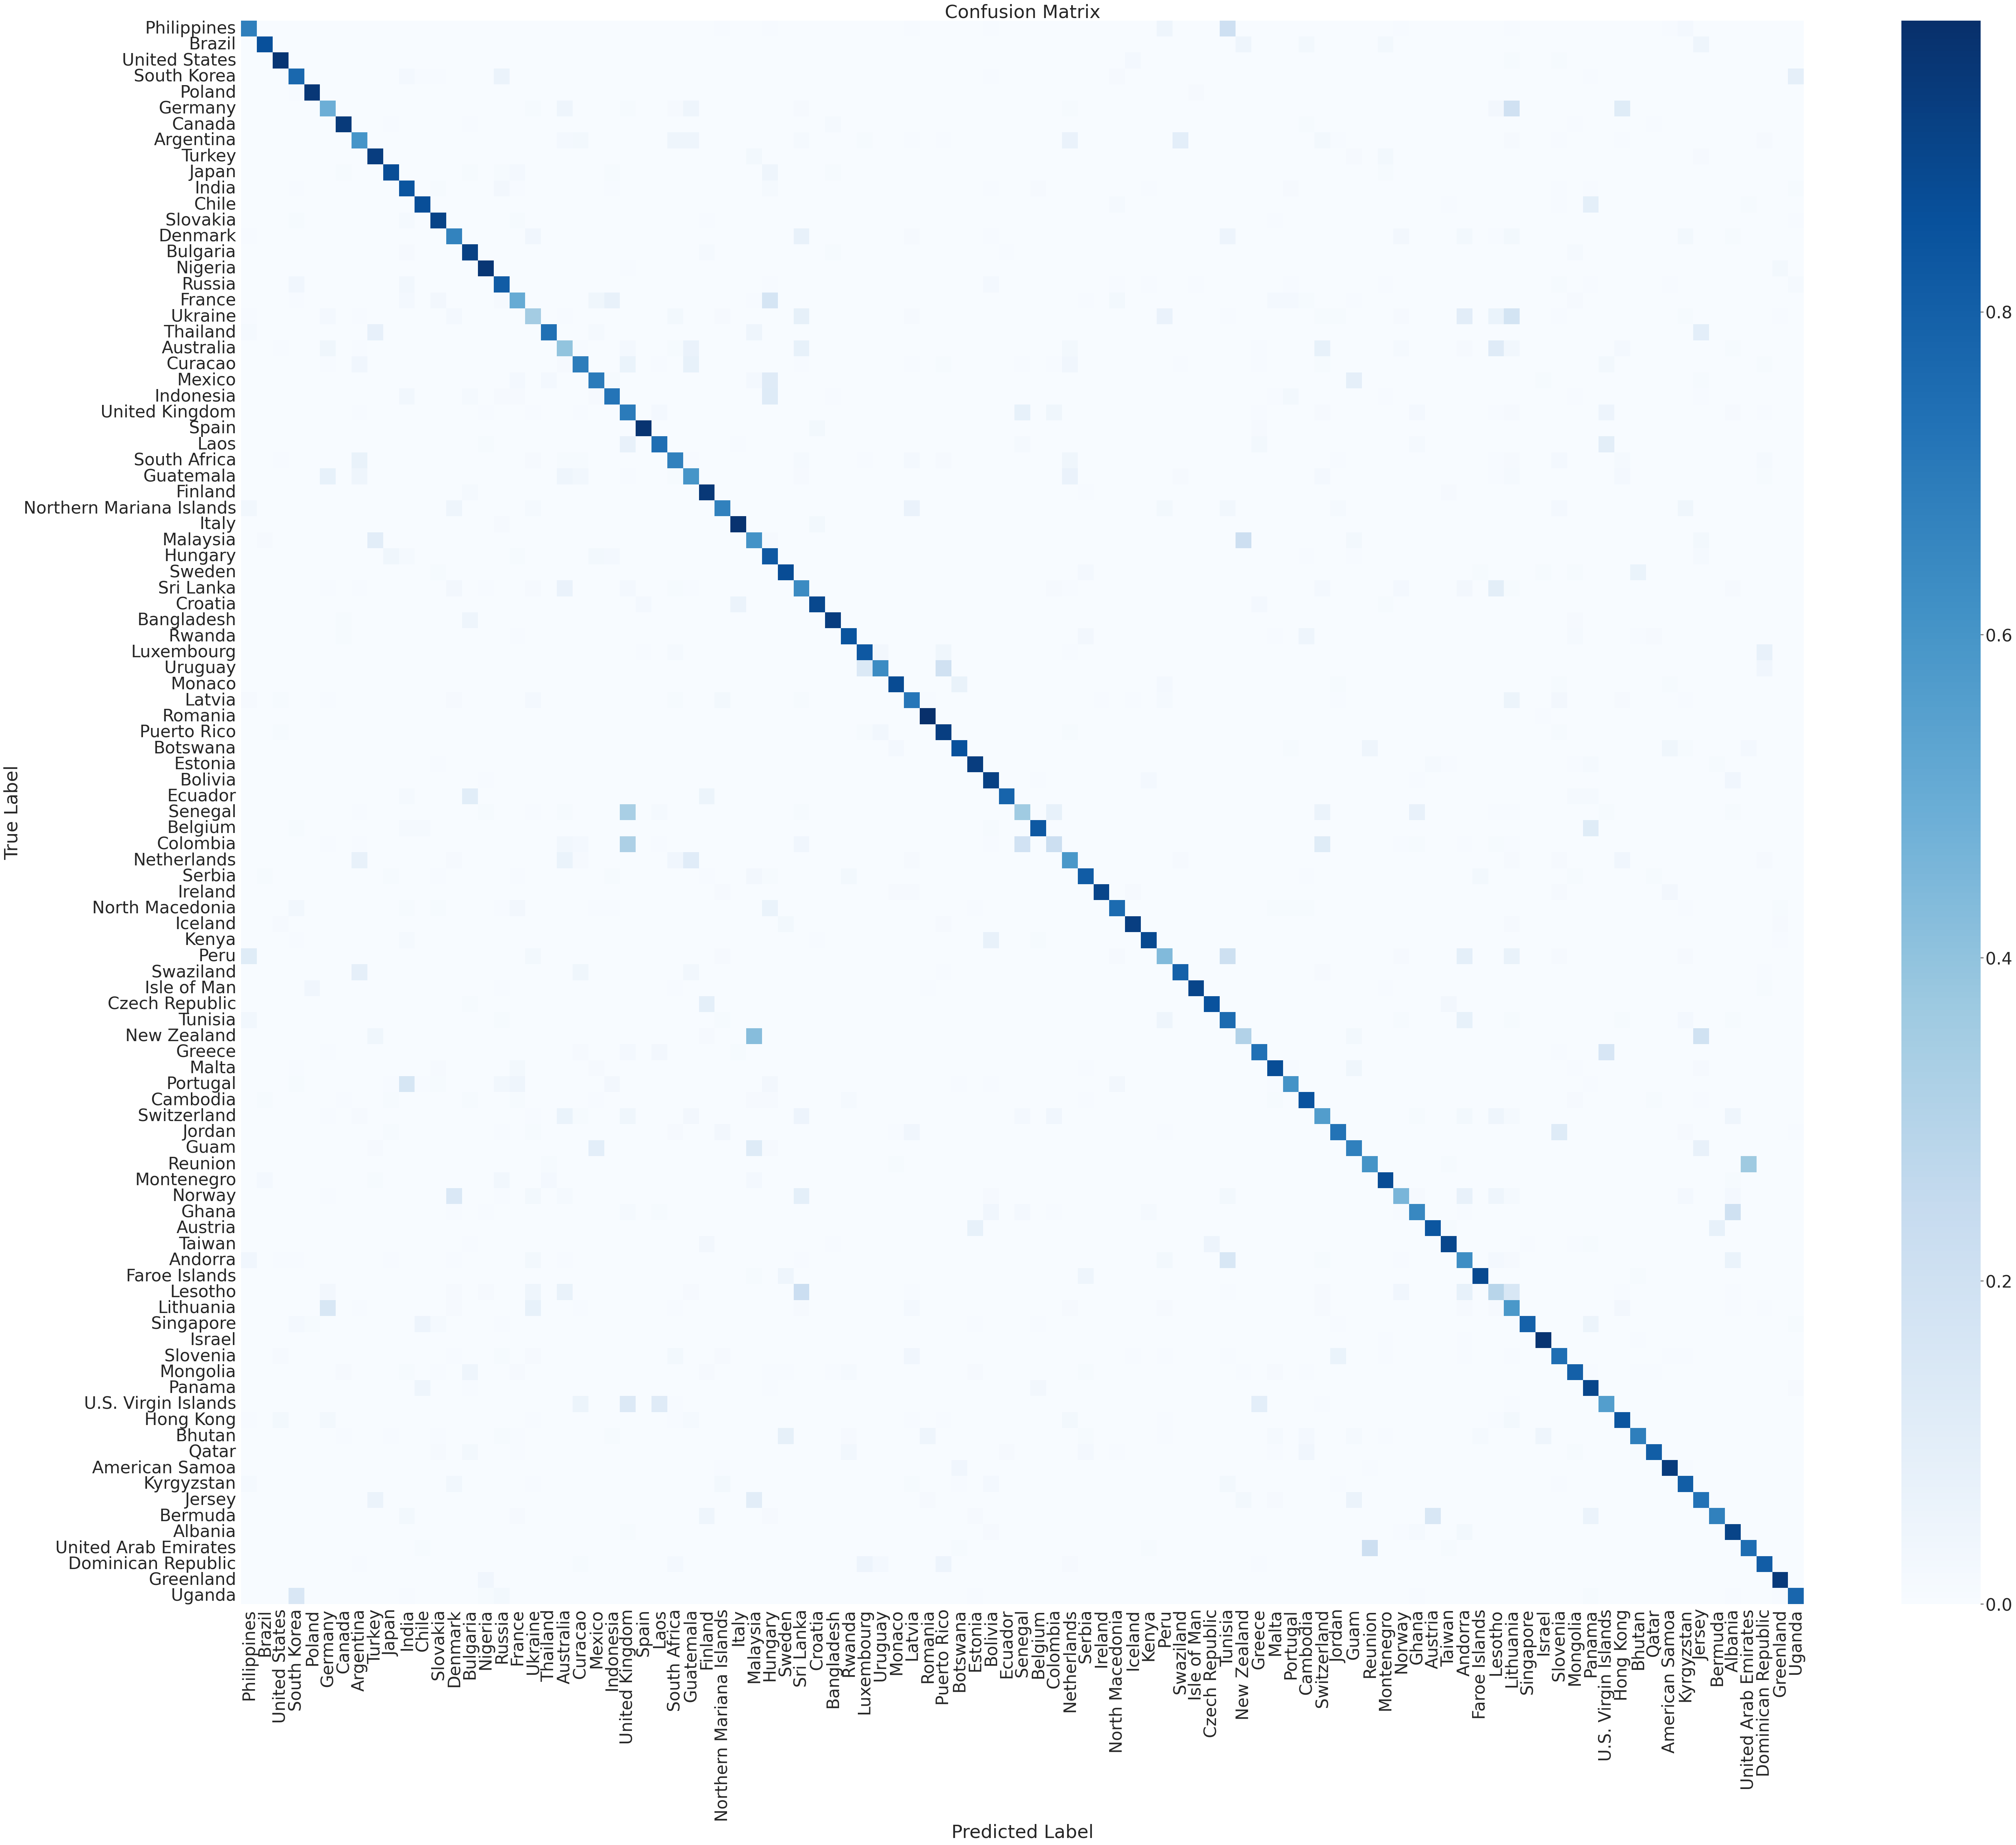

In [44]:
plt.figure(figsize=(60, 50))

sns.set_theme(font_scale=3)
sns.heatmap(relative_confusion_matrix_2, annot=False, cmap="Blues", fmt="d", xticklabels=countries, yticklabels=countries)
# plt.xticks(rotation=75)  # 'ha' parameter aligns the labels to the right
plt.tight_layout() 
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig('cm_country_largemodel.png')

In [24]:
# row_sums = confusion_matrix_country.sum(axis=1)  # Sum of each row
# relative_confusion_matrix = confusion_matrix_country / row_sums[:, np.newaxis]


Text(0.5, 1.0, 'Confusion Matrix')

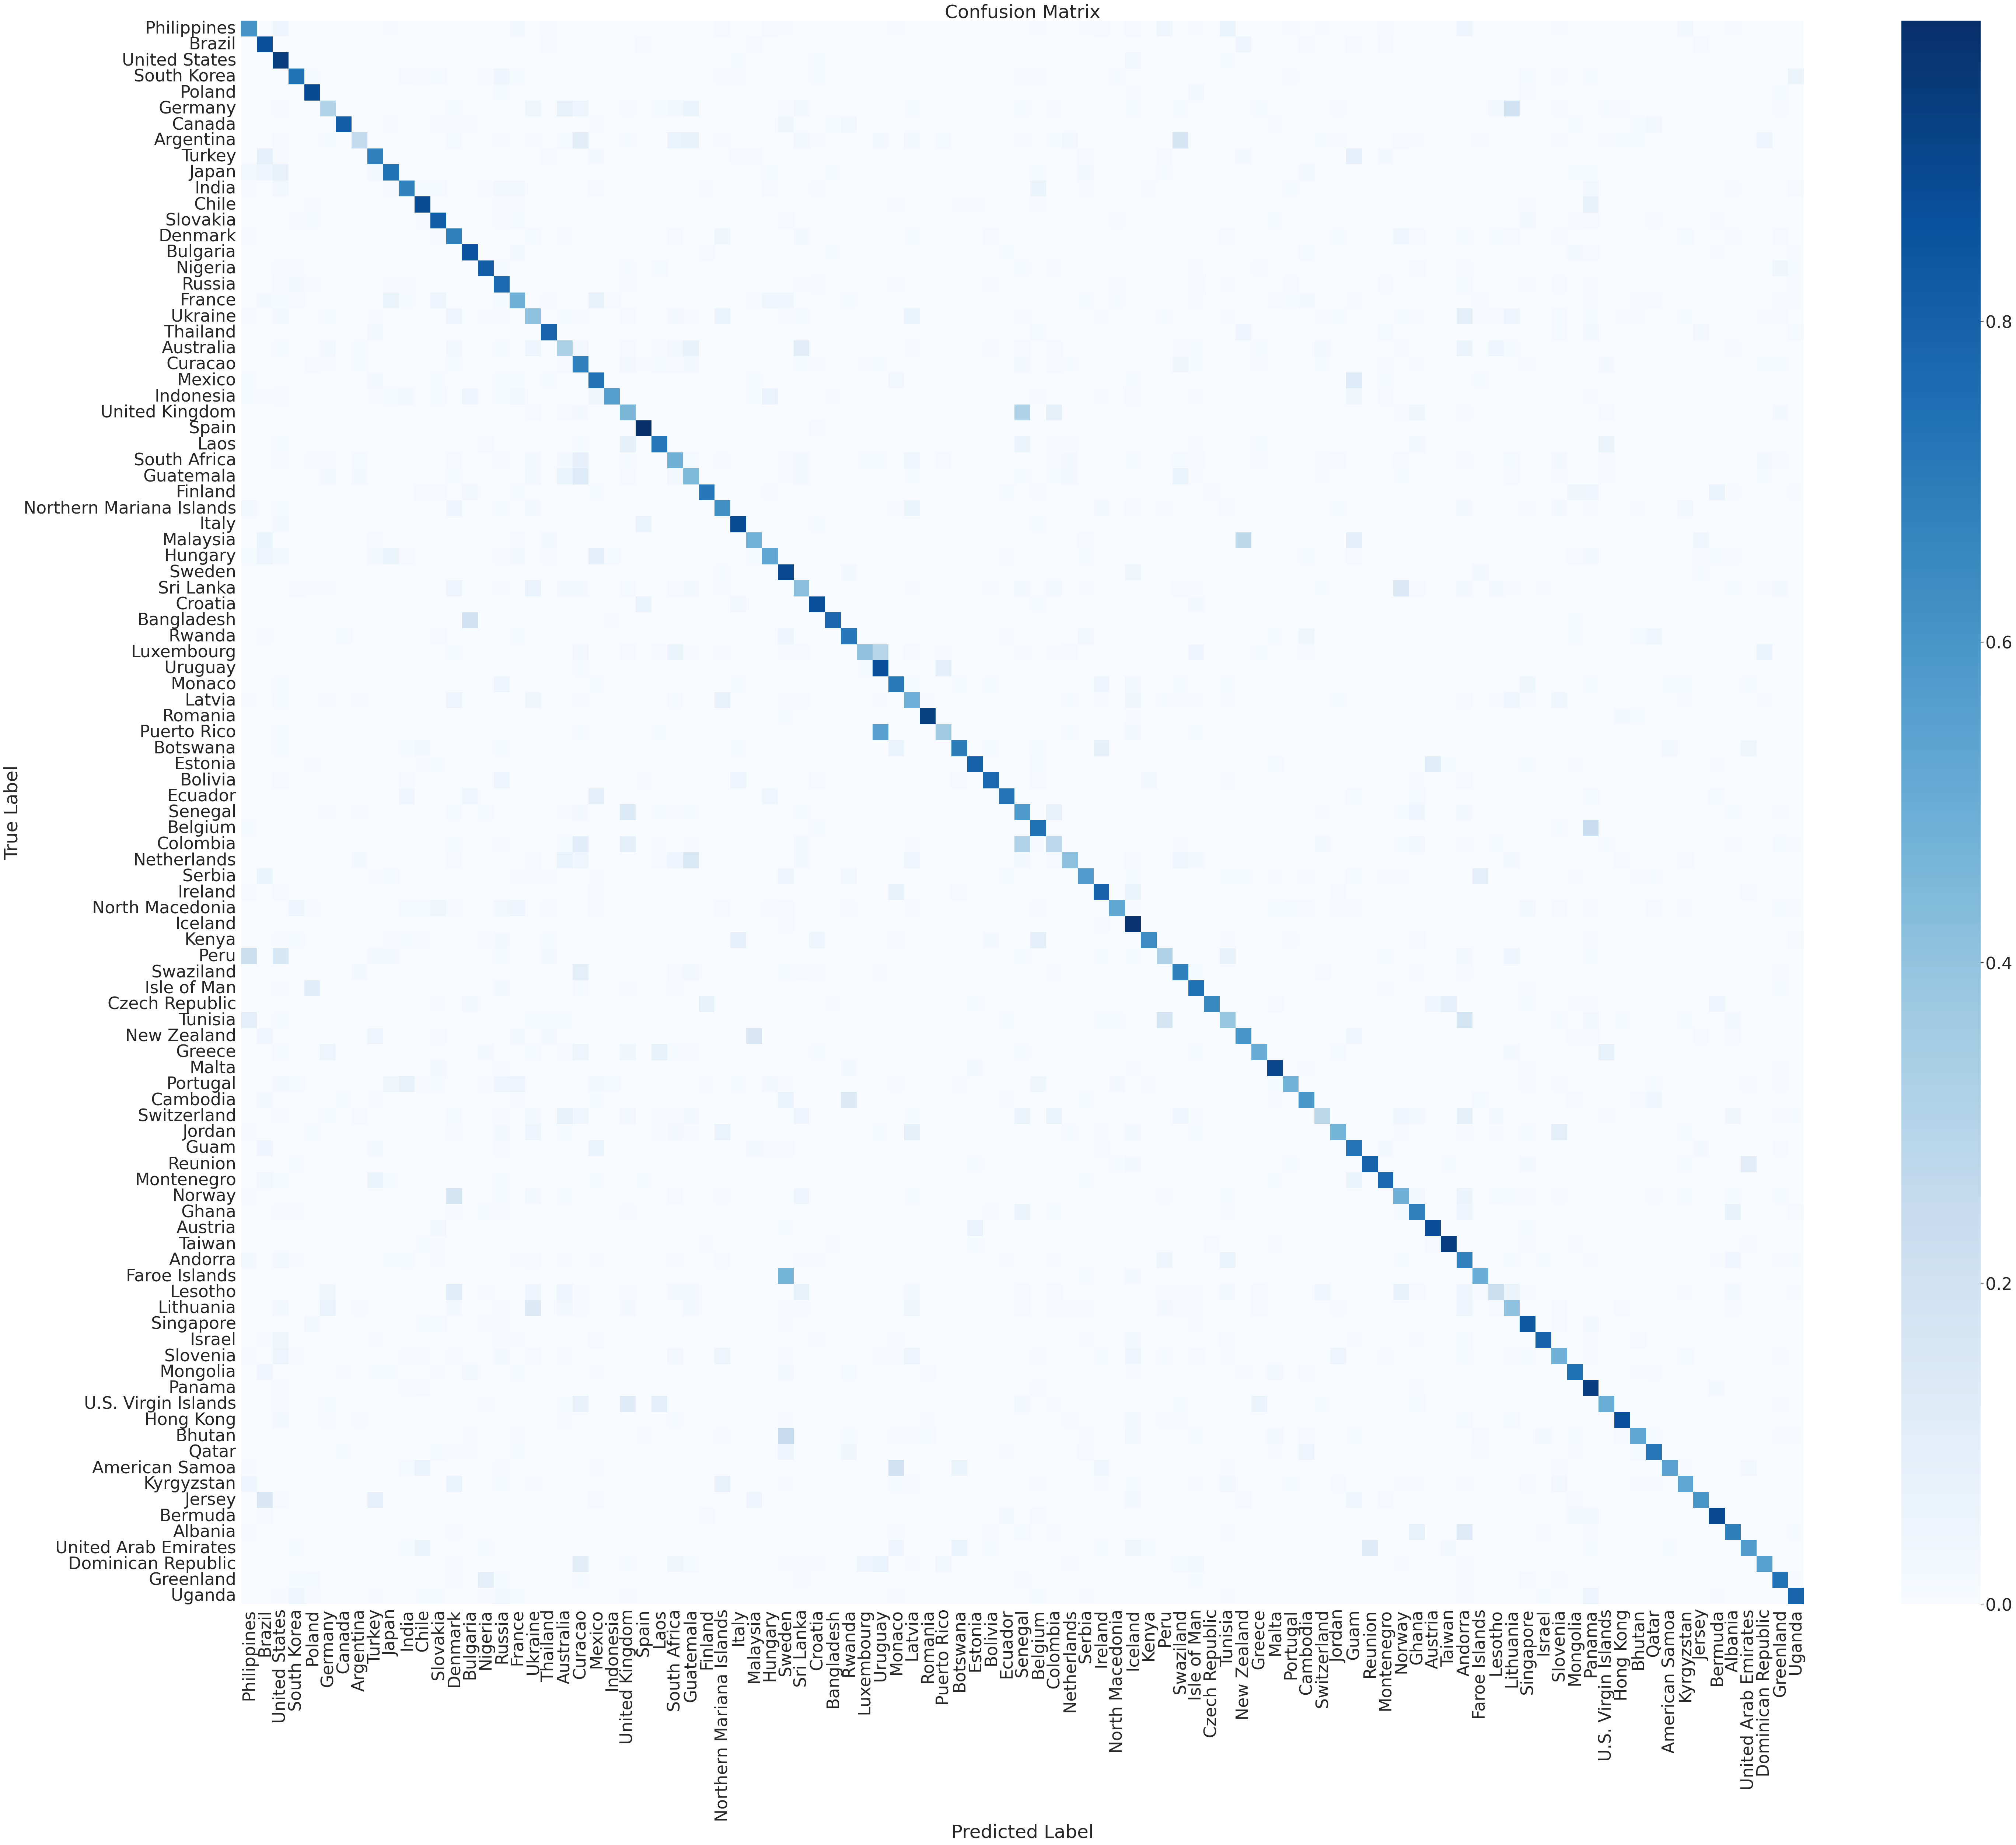

In [45]:
plt.figure(figsize=(60, 50))

sns.set_theme(font_scale=3)
sns.heatmap(relative_confusion_matrix, annot=False, cmap="Blues", fmt="d", xticklabels=countries, yticklabels=countries)
# plt.xticks(rotation=75)  # 'ha' parameter aligns the labels to the right
plt.tight_layout() 
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

In [ ]:
plt.figure(figsize=(50, 50))

sns.set_theme(font_scale=1.2)
sns.heatmap(confusion_matrix_climate, annot=False, cmap="Blues", fmt="d", xticklabels=climates, yticklabels=climates)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")